In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import wfdb
import glob
import random
import warnings
import tempfile
import shutil
import seaborn as sns

from scipy.signal import butter, filtfilt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model # type: ignore
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.losses import BinaryCrossentropy # type: ignore
from tensorflow.keras.metrics import BinaryAccuracy # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint # type: ignore

FOLDER_PATH = '24h-emgcg/'
FOLDER_SAMPLE = '24h-ecg-sample/'
FOLDER_NORMALIZE = '24h-ecg-normalized/'
FOLDER_FILTER = '24h-ecg-normalized-filter/'
DATASET_QC = "dataset-qc-model/"
DATASET_QC_TEST = "dataset-qc-test/"
MODEL = "model/"
PHYSIONET_PATH = 'cves/1.0.0/data/24h-electromyography'
PHYSIONET_DIR = 'cves'
LABEL_FILE = "label.txt"

# CONVERT TO p_signal FILES USING 2 CHANNEL ecg_0 vs ecg_1

In [2]:

record_files = [f for f in os.listdir(FOLDER_PATH) if f.endswith('.hea')]

records_missing_dat = []

records_exist = []

records_header_error = []

for record_file in record_files:
    record_name = os.path.splitext(record_file)[0]
    if not os.path.exists(os.path.join(FOLDER_PATH, f"{record_name}.dat")):
        records_missing_dat.append(record_name)
        continue  
    
    output_file_path = os.path.join(FOLDER_PATH, f"{record_name}_p_signal.txt")
    
    if os.path.exists(output_file_path):
        records_exist.append(record_file)
        continue  
    
    try:
        record = wfdb.rdrecord(os.path.join(FOLDER_PATH, record_name), channels=[0, 1])
    except Exception as e:
        if isinstance(e, FileNotFoundError):
            records_missing_dat.append(record_name)
        else:
            print(f"Error processing {record_name}: {str(e)}")
            records_header_error.append(record_name)
        continue
    
    signals = record.p_signal
    
    with open(output_file_path, 'w') as file:
        for signal in signals:
            file.write(f"{signal[0]}\t{signal[1]}\n")

print("Conversion completed.")
if records_missing_dat:
    print("The following records were skipped due to missing .dat files:")
    print(records_missing_dat)
if records_header_error:
    print("The following records had header syntax errors:")
    print(records_header_error)
print(f"Number of records converted: {len(record_files) - len(records_missing_dat) - len(records_header_error)}")

Conversion completed.
Number of records converted: 0


# DELETE ALL .dat .hea .maker files

In [3]:
extensions = ['.dat', '.hea', '.marker']

def delete_files_if_txt_exists(folder_path):
    for ext in extensions:
        file_pattern = os.path.join(folder_path, f'*{ext}')
        files = glob.glob(file_pattern)
        for file_path in files:
            base_name = os.path.splitext(os.path.basename(file_path))[0]
            txt_file_path = os.path.join(folder_path, f'{base_name}_p_signal.txt')
            if os.path.exists(txt_file_path):
                try:
                    os.remove(file_path)
                    print(f"Deleted: {file_path}")
                except OSError as e:
                    print(f"Error: {file_path} - {e.strerror}")

delete_files_if_txt_exists(FOLDER_PATH)

# CONVERT BY CALL PHYSIONET

In [6]:

os.makedirs(FOLDER_PATH, exist_ok=True)

for record_name in record_files:
    # Define the path for the expected .p_signal output file
    output_file_path = os.path.join(FOLDER_PATH, f"{record_name}_p_signal.txt")
    
    # Check if the .p_signal file already exists
    if os.path.exists(output_file_path):
        print(f"File {output_file_path} already exists. Skipping...")
        continue

    # Read the specified channels (0 and 1) from the record directly from PhysioNet
    # Note: This step requires an internet connection and access permissions to the data
    record = wfdb.rdrecord(record_name, pn_dir=PHYSIONET_PATH, channels=[0, 1])

    # Extract the signals for channels 0 and 1
    signals = record.p_signal

    # Write the signals to the output file
    with open(output_file_path, 'w') as file:
        for signal in signals:
            # Write each signal sample to the file, separated by a tab
            file.write(f"{signal[0]}\t{signal[1]}\n")

print("Conversion completed. Check the local directory for the .p_signal files.")


File 24h-emgcg/s0030-04051907_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0030-04051908_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0044-05062806_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0044-05062807_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0064-05081805_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0064-05081806_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0067-05040508_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0067-05040509_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0067-05040510_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0067-05040511_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0068-05022417_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0068-05022418_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0121-04042801_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0121-04042802_p_signal.txt already exists. Skipping...
File 2

# CONVERT SIGNAL FROM uV to mV 

In [3]:

for filename in os.listdir(FOLDER_PATH):
    file_path = os.path.join(FOLDER_PATH, filename)
    if os.path.isfile(file_path):
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as temp_file:
            with open(file_path, 'r') as file:
                for line in file:
                    values = line.split()
                    modified_values = [str(float(value)/1000) for value in values]
                    temp_file.write('\t'.join(modified_values) + '\n')

        shutil.copy(temp_file.name, file_path)
        os.remove(temp_file.name)

print("All files have been modified.")

All files have been modified.


# Function get list of file names, plot data in range,...

In [4]:

# List file names from folder name
def get_main_names_of_files(x):
    file_names = os.listdir(x)
    main_names = [name.split('_p_signal.txt')[0] for name in file_names if name.endswith('_p_signal.txt')]
    return main_names

# PLOT SIGNAL IN RANGE(m , n) BY FILENAME
def plot_ecg_signal(main_name_of_file, folder_path, n, m=0):
    # start m end n
    file_path = os.path.join(folder_path, f'{main_name_of_file}_p_signal.txt')
    if not os.path.exists(file_path):
        print(f'File {file_path} does not exist.')
        return
    try:
        # Load the data with a maximum of n rows
        warnings.filterwarnings("ignore", message="Input line contained no data")
        total_data = np.loadtxt(file_path, max_rows=n)
        total_rows = total_data.shape[0]
        if m < 0 or n > total_rows or m >= n:
            raise ValueError(f"Invalid range: {m} to {n}. File contains {total_rows} rows.")
        data_segment = total_data[m:n, :]
    except Exception as e:
        print(f"Error reading the file: {e}")
        return
    time = np.arange(m, n) * 1  # 1 ms per sample
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time, data_segment[:, 0])
    plt.title('Channel 1')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (mV)')
    plt.subplot(2, 1, 2)
    plt.plot(time, data_segment[:, 1])
    plt.title('Channel 2')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (mV)')
    
    plt.tight_layout()
    plt.show()

def count_rows_in_file(prefix, directory):
    suffix = '_p_signal.txt'
    filename = prefix + suffix
    file_path = os.path.join(directory, filename)
    
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            return len(lines)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

names = get_main_names_of_files(FOLDER_PATH)

print("Main names of files:", names)
print(len(names))


Main names of files: ['s0322-07052204', 's0242-06012405', 's0184-05091311', 's0335-07040503', 's0231-05111709', 's0175-05030325', 's0376-07091805', 's0221-06082208', 's0208-05102508', 's0153-05021018', 's0225-06022111', 's0218-05110113', 's0351-07062105', 's0230-06013111', 's0197-05060906', 's0358-07071203', 's0358-07071204', 's0247-06050205', 's0376-07091804', 's0221-06082209', 's0208-05102509', 's0184-05091310', 's0239-06012607', 's0164-06033006', 's0157-05062311', 's0322-07052205', 's0231-05111708', 's0232-06060108', 's0204-05092907', 's0230-06013110', 's0351-07062104', 's0354-07051506', 's0187-05040711', 's0164-06033107', 's0218-05110112', 's0331-07031501', 's0210-05092012', 's0153-05021019', 's0030-04051907', 's0132-04102801', 's0207-05090814', 's0215-06030712', 's0305-06113004', 's0361-07080906', 's0166-05031008', 's0352-07060705', 's0305-06113003', 's0214-05110807', 's0352-07060702', 's0154-05050307', 's0160-04052807', 's0174-05062113', 's0336-07041701', 's0348-07052402', 's0221

# RAMDOMLY SAMPLE 100 NON-OVERLAPPING SEGMENTS EACH SIGNAL 

In [29]:
sampling_rate = 1000  # Freq definition
segment_length_ms = 6000
segment_length_samples = int(sampling_rate * (segment_length_ms / 1000))

max_segments = 100

for filename in os.listdir(FOLDER_PATH):
    if filename.endswith('.txt') and 'p_signal' in filename:
        file_path = os.path.join(FOLDER_PATH, filename)
        output_base_filename = filename.replace('_p_signal.txt', '')

        with open(file_path, 'r') as file:
            data = file.readlines()

        # Maximum number of segments possible
        possible_segments = min(max_segments, len(data) // segment_length_samples)

        # Calculate start points for each segment
        start_indices = sorted(random.sample(range(0, len(data) - segment_length_samples + 1), possible_segments))

        for i, start in enumerate(start_indices):
            segment = data[start:start + int(segment_length_samples)]
            segment_filename = f"{output_base_filename}_{i + 1}_p_signal.txt"
            segment_file_path = os.path.join(FOLDER_SAMPLE, segment_filename)

            with open(segment_file_path, 'w') as outfile:
                outfile.writelines(segment)

        print(f"Processed {filename} into {possible_segments} segments.")

print("Sampling complete.")

Processed s0322-07052204_p_signal.txt into 100 segments.
Processed s0242-06012405_p_signal.txt into 100 segments.
Processed s0184-05091311_p_signal.txt into 100 segments.
Processed s0335-07040503_p_signal.txt into 100 segments.
Processed s0231-05111709_p_signal.txt into 100 segments.
Processed s0175-05030325_p_signal.txt into 100 segments.
Processed s0376-07091805_p_signal.txt into 100 segments.
Processed s0221-06082208_p_signal.txt into 2 segments.
Processed s0208-05102508_p_signal.txt into 100 segments.
Processed s0153-05021018_p_signal.txt into 100 segments.
Processed s0225-06022111_p_signal.txt into 100 segments.
Processed s0218-05110113_p_signal.txt into 100 segments.
Processed s0351-07062105_p_signal.txt into 100 segments.
Processed s0230-06013111_p_signal.txt into 100 segments.
Processed s0197-05060906_p_signal.txt into 100 segments.
Processed s0358-07071203_p_signal.txt into 100 segments.
Processed s0358-07071204_p_signal.txt into 100 segments.
Processed s0247-06050205_p_signal

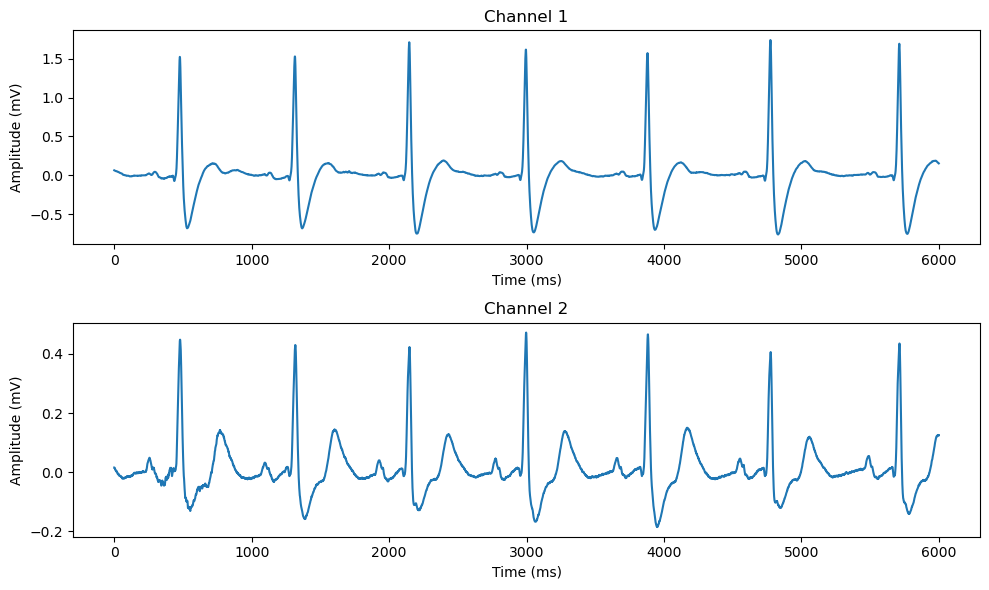

In [5]:
# CHECK DATA BY PLOT SIGNAL

# plot_ecg_signal('s0402', FOLDER_SAMPLE, 40000, 34000)
plot_ecg_signal('s0402-08010704_1', FOLDER_SAMPLE, 6000)
# plot_ecg_signal('s0402-08010704', FOLDER_PATH, 50000000)

# Normalizing datas after sampling

In [33]:
source_directory = FOLDER_SAMPLE
destination_directory = FOLDER_NORMALIZE

scaler = MinMaxScaler()

for filename in os.listdir(source_directory):
    if filename.endswith('.txt'):
        file_path = os.path.join(source_directory, filename)
        
        # Load the data from the file
        data = np.loadtxt(file_path)

        # Check if the data is in two columns or a single column
        if data.ndim == 1:
            # If it's a single column, reshape for the scaler
            data = data.reshape(-1, 1)

        # Apply the MinMaxScaler to the data
        normalized_data = scaler.fit_transform(data)
        
        dest_file_path = os.path.join(destination_directory, filename)
        np.savetxt(dest_file_path, normalized_data)

print("All files have been normalized.")

All files have been normalized.


# Smoothing datas after normalization by ButterWorth filter to folder FOLDER_FILTER

In [7]:
def extract_columns(file_name):
    full_file_path = os.path.join(FOLDER_NORMALIZE, file_name)
    
    data = np.loadtxt(full_file_path)
    
    left = data[:, 0]
    return left

def compute(smooth):
    first_derivative = np.gradient(smooth, 10)
    second_derivative = np.gradient(first_derivative, 10)
    return first_derivative, second_derivative

# Function to apply the low-pass filter
def butterworth_filter(signal):
    cutoff_frequency = 11  # Cutoff frequency in Hz
    sampling_rate = 1000  # Sampling rate in Hz
    order = 2  # Order of the polynomial
    # divide by (0.5 * sampling_rate)
    # frequencies are often normalized by the Nyquist frequency
    # which is half the sampling rate. 
    # The Nyquist frequency is the highest frequency that can be effectively 
    # sampled without introducing aliasing according to the Nyquist-Shannon sampling theorem.
    b, a = butter(order, cutoff_frequency / (0.5 * sampling_rate), btype='low')
    return filtfilt(b, a, signal)

In [ ]:

for filename in os.listdir(FOLDER_NORMALIZE):
    if filename.endswith('p_signal.txt'):
        destination_file_path = os.path.join(FOLDER_FILTER, filename)
        
        data = extract_columns(filename)
        smoothed = butterworth_filter(data)
        hi_freq = data - smoothed
        first_der, second_der = compute(smoothed)
        
        # Write the smoothed data, high-frequency data, and derivatives to a new file
        with open(destination_file_path, 'w') as file:
            for i in range(len(data)):
                file.write(f"{data[i]}\t{smoothed[i]}\t{hi_freq[i]}\t{first_der[i]}\t{second_der[i]}\n")

print("Filtering complete.")

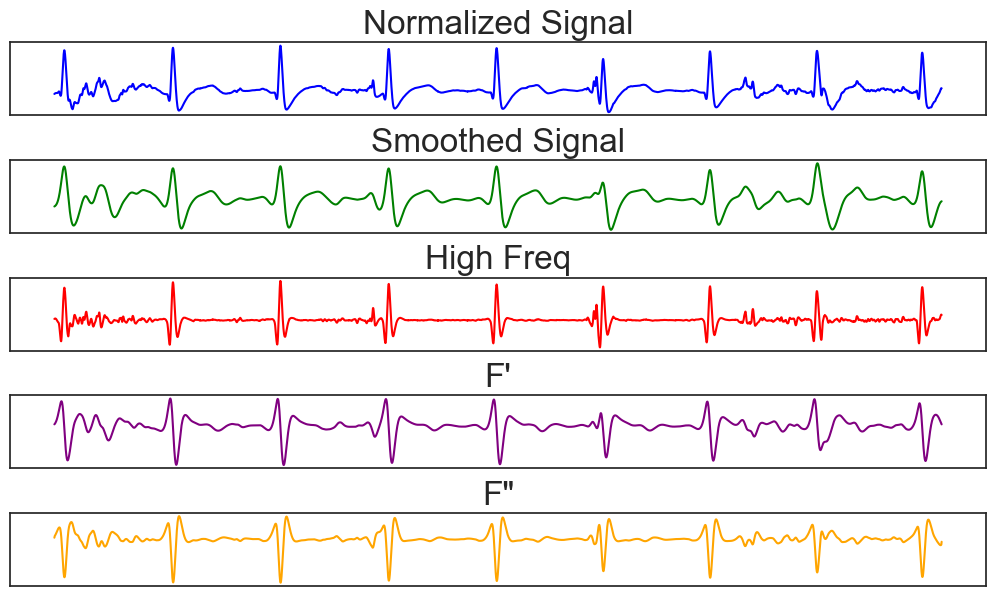

In [53]:
def plotpp(filename):
    data = extract_columns(filename)
    smoothed = butterworth_filter(data)
    hi_freq = data - smoothed
    first_der, second_der = compute(smoothed)
    colors = ['blue', 'green', 'red', 'purple', 'orange']

    plt.figure(figsize=(10, 6)) 
    plt.rcParams.update({'font.size': 8})

    plt.subplot(5, 1, 1)
    plt.plot(data, color=colors[0])
    plt.title('Normalized Signal')
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.subplot(5, 1, 2)
    plt.plot(smoothed, color=colors[1])
    plt.title('Smoothed Signal')
    
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.subplot(5, 1, 3)
    plt.plot(hi_freq, color=colors[2])
    plt.title('High Freq')
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.subplot(5, 1, 4)
    plt.plot(first_der, color=colors[3])
    plt.title('F\'')
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.subplot(5, 1, 5)
    plt.plot(second_der, color=colors[4])
    plt.title('F\"')
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.tight_layout()
    plt.show()

plotpp('s0030-04051907_15_p_signal.txt')


# Clone randomly 4 segments each subject for training 
# 797 segments collected

In [15]:
with open(os.path.join(DATASET_QC, LABEL_FILE), 'w') as label:
    for name in names:
        file = [file for file in os.listdir(FOLDER_FILTER) if file.startswith(name)]
        count_clone = min(4, len(file))  
        files_to_copy = random.sample(file, count_clone)
        for file_name in files_to_copy:
            source_file_path = os.path.join(FOLDER_FILTER, file_name)
            destination_file_path = os.path.join(DATASET_QC, file_name)
            shutil.copyfile(source_file_path, destination_file_path)
            label.write(f"{file_name} 1\n")

# Function for paging and manual label

In [9]:
def label(file_name):
    with open(os.path.join(DATASET_QC, LABEL_FILE), 'r+') as label_file:
        lines = label_file.readlines()
        label_file.seek(0)
        for line in lines:
            if file_name in line:
                line = line.replace(" 1", " 0")
            label_file.write(line)
        label_file.truncate()
        
def revert(file_name):
    with open(os.path.join(DATASET_QC, LABEL_FILE), 'r+') as label_file:
        lines = label_file.readlines()
        label_file.seek(0)
        for line in lines:
            if file_name in line:
                line = line.replace(" 0", " 1")
            label_file.write(line)
        label_file.truncate()
        
def paging(data, page, page_size):
  if page <= 0 or page_size <= 0:
    return [] 

  start_index = (page - 1) * page_size
  end_index = start_index + page_size

  if end_index > len(data):
    end_index = len(data)

  return data[start_index:end_index]

dataset = get_main_names_of_files(DATASET_QC)
dataset.sort()
print(dataset)

data = paging(dataset, 1, 2)
print(data)

['s0030-04051907_15', 's0030-04051907_36', 's0030-04051907_53', 's0030-04051907_78', 's0030-04051908_26', 's0030-04051908_30', 's0030-04051908_35', 's0030-04051908_7', 's0044-05062806_26', 's0044-05062806_29', 's0044-05062806_35', 's0044-05062806_46', 's0044-05062807_13', 's0044-05062807_33', 's0044-05062807_56', 's0044-05062807_74', 's0064-05081805_15', 's0064-05081805_40', 's0064-05081805_89', 's0064-05081805_97', 's0064-05081806_26', 's0064-05081806_73', 's0064-05081806_88', 's0064-05081806_91', 's0067-05040508_34', 's0067-05040508_57', 's0067-05040508_64', 's0067-05040508_95', 's0067-05040509_2', 's0067-05040509_3', 's0067-05040509_6', 's0067-05040509_7', 's0067-05040510_25', 's0067-05040510_35', 's0067-05040510_50', 's0067-05040510_59', 's0067-05040511_47', 's0067-05040511_48', 's0067-05040511_82', 's0067-05040511_97', 's0068-05022417_100', 's0068-05022417_17', 's0068-05022417_18', 's0068-05022417_82', 's0068-05022418_15', 's0068-05022418_70', 's0068-05022418_82', 's0068-05022418_

# Get list signal by pagination and grid plot

s0172-05071906_51_p_signal.txt
s0277-06090703_96_p_signal.txt
s0352-07060703_27_p_signal.txt
s0221-06082206_3_p_signal.txt
s0331-07031504_36_p_signal.txt
s0321-07022206_90_p_signal.txt
s0335-07040503_7_p_signal.txt
s0352-07060703_20_p_signal.txt
s0239-06012607_63_p_signal.txt
s0210-05092012_12_p_signal.txt
s0371-07091105_94_p_signal.txt
s0044-05062806_35_p_signal.txt
s0221-06082206_4_p_signal.txt
s0363-07072604_51_p_signal.txt
s0184-05091310_56_p_signal.txt
s0378-07100403_1_p_signal.txt
s0321-07022206_97_p_signal.txt
s0218-05110113_94_p_signal.txt
s0340-07050204_51_p_signal.txt
s0248-06041808_17_p_signal.txt
s0334-07040303_42_p_signal.txt
s0153-05021019_5_p_signal.txt
s0160-04052807_76_p_signal.txt
s0331-07031503_13_p_signal.txt


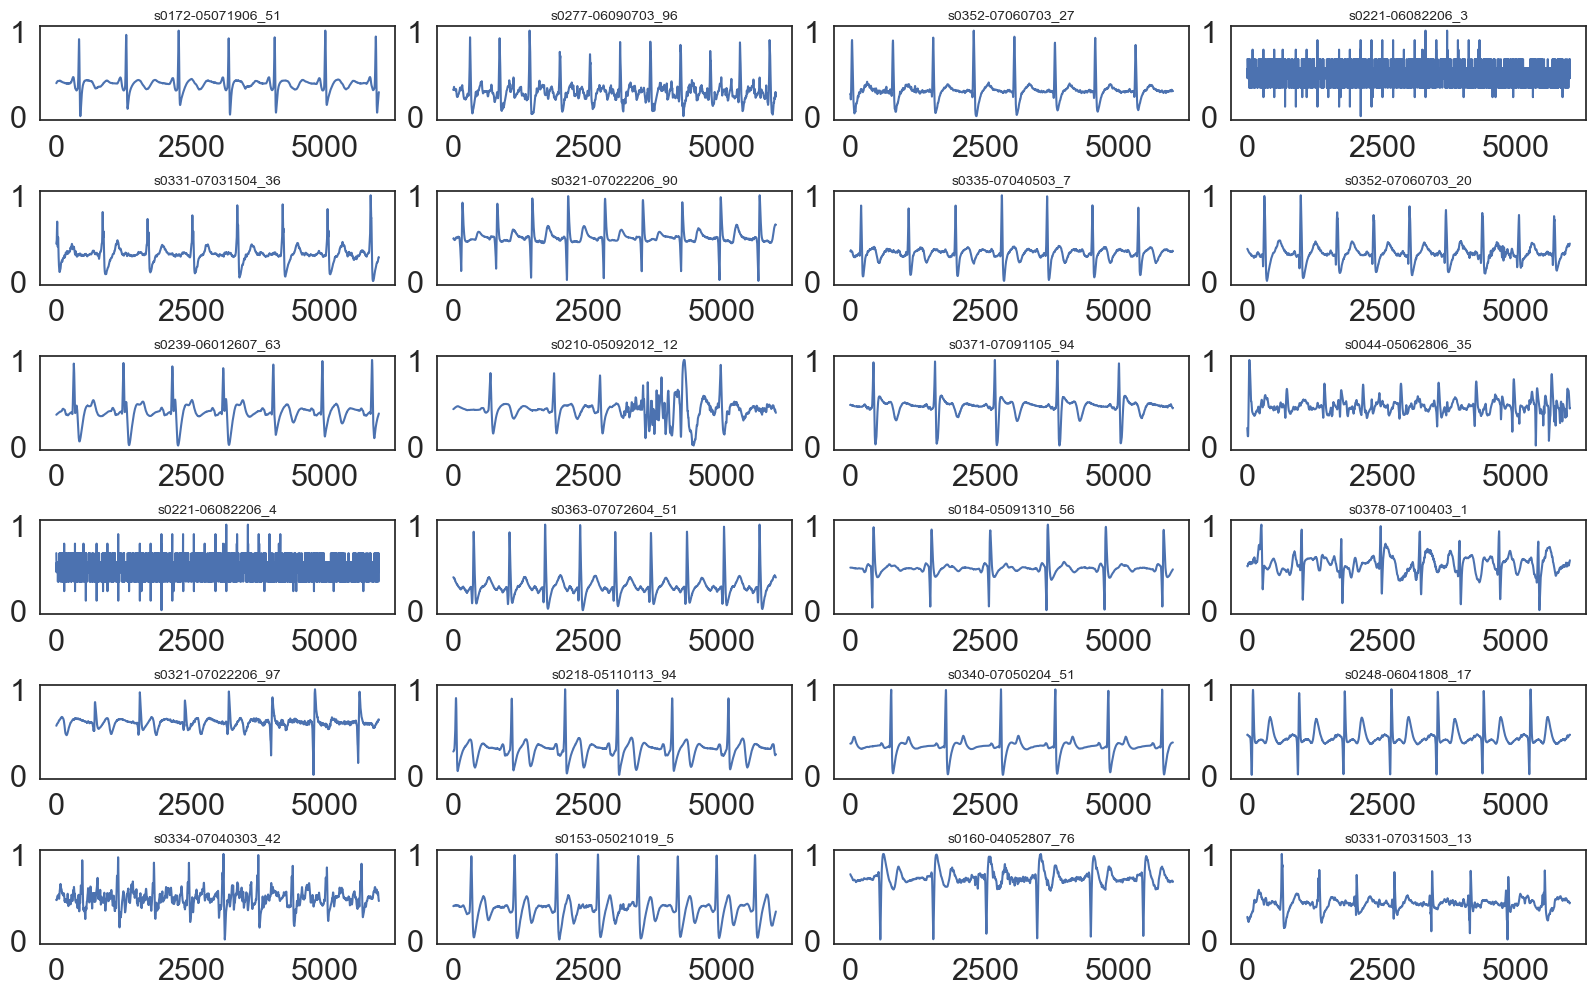

In [74]:
def grid_plot(folder, page, pageSize = 24, num_cols = 4):
    dataset = get_main_names_of_files(folder)
    file_names = paging(dataset, page, pageSize)

    num_plots = len(file_names)
    num_cols = num_cols
    num_rows = int(np.ceil(num_plots / num_cols))

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 10))

    for i, file_name in enumerate(file_names):
        print(f'{file_name}_p_signal.txt')
        title = file_name
        file_name = os.path.join(folder, f'{file_name}_p_signal.txt')
        
        row = i // num_cols
        col = i % num_cols
        data = np.loadtxt(file_name) 
        data = data[:,0]
        axs[row, col].plot(data)
        axs[row, col].set_title(title, size=10)
        
    for i in range(num_plots, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()

grid_plot(DATASET_QC, 1, 24, 4)

# Check data drawn and call method label manually

In [11]:
label('s0030-04051907_53_p_signal.txt')
label('s0044-05062806_26_p_signal.txt')
label('s0044-05062806_35_p_signal.txt')
label('s0064-05081805_40_p_signal.txt')
label('s0064-05081805_89_p_signal.txt')
label('s0064-05081806_88_p_signal.txt')
label('s0067-05040509_2_p_signal.txt')
label('s0067-05040509_3_p_signal.txt')
label('s0067-05040509_6_p_signal.txt')
label('s0067-05040509_7_p_signal.txt')
label('s0067-05040510_25_p_signal.txt')
label('s0067-05040510_35_p_signal.txt')
label('s0067-05040510_50_p_signal.txt')
label('s0067-05040510_59_p_signal.txt')
label('s0068-05022417_100_p_signal.tx')
label('s0068-05022417_18_p_signal.txt')
label('s0068-05022417_82_p_signal.txt')
label('s0068-05022418_15_p_signal.txt')
label('s0068-05022418_82_p_signal.txt')
label('s0121-04042801_71_p_signal.txt')
label('s0132-04102802_72_p_signal.txt')
label('s0153-05021018_100_p_signal.tx')
label('s0153-05021018_41_p_signal.txt')
label('s0154-05050307_72_p_signal.txt')
label('s0160-04052807_76_p_signal.txt')
label('s0160-04052808_13_p_signal.txt')
label('s0163-04060411_47_p_signal.txt')
label('s0163-04060411_49_p_signal.txt')
label('s0164-06033004_90_p_signal.txt')
label('s0164-06033107_75_p_signal.txt')
label('s0164-06033107_99_p_signal.txt')
label('s0165-05092209_95_p_signal.txt')
label('s0166-05031008_46_p_signal.txt')
label('s0166-05031009_29_p_signal.txt')
label('s0166-05031009_41_p_signal.txt')
label('s0174-05062111_37_p_signal.txt')
label('s0174-05062111_76_p_signal.txt')
label('s0174-05062111_93_p_signal.txt')
label('s0176-04060217_3_p_signal.txt')
label('s0176-04060217_87_p_signal.txt')
label('s0178-05041205_86_p_signal.txt')
label('s0184-05091310_82_p_signal.txt')
label('s0184-05091311_13_p_signal.txt')
label('s0194-05071408_65_p_signal.txt')
label('s0197-05060905_16_p_signal.txt')
label('s0197-05060905_21_p_signal.txt')
label('s0199-05041912_97_p_signal.txt')
label('s0199-05041913_37_p_signal.txt')
label('s0207-05090822_10_p_signal.txt')
label('s0207-05090822_9_p_signal.txt')
label('s0210-05092012_12_p_signal.txt')
label('s0212-05111011_22_p_signal.txt')
label('s0213-05092707_64_p_signal.txt')
label('s0218-05110112_58_p_signal.txt')
label('s0221-06082202_1_p_signal.txt')
label('s0221-06082203_1_p_signal.txt')
label('s0221-06082204_1_p_signal.txt')
label('s0221-06082205_1_p_signal.txt')
label('s0221-06082205_2_p_signal.txt')
label('s0221-06082205_3_p_signal.txt')
label('s0221-06082206_2_p_signal.txt')
label('s0221-06082206_3_p_signal.txt')
label('s0221-06082206_4_p_signal.txt')
label('s0221-06082206_5_p_signal.txt')
label('s0221-06082210_74_p_signal.txt')
label('s0221-06082210_75_p_signal.txt')
label('s0221-06082209_96_p_signal.txt')
label('s0225-06022111_4_p_signal.txt')
label('s0227-06020209_85_p_signal.txt')
label('s0230-06013110_22_p_signal.txt')
label('s0230-06013110_5_p_signal.txt')
label('s0230-06013110_52_p_signal.txt')
label('s0230-06013110_91_p_signal.txt')
label('s0230-06013111_40_p_signal.txt')
label('s0230-06013111_43_p_signal.txt')
label('s0230-06013111_72_p_signal.txt')
label('s0230-06013111_84_p_signal.txt')
label('s0231-05111708_52_p_signal.txt')
label('s0231-05111708_90_p_signal.txt')
label('s0239-06012608_18_p_signal.txt')
label('s0240-06030215_14_p_signal.txt')
label('s0240-06030216_59_p_signal.txt')
label('s0247-06050206_1_p_signal.txt')
label('s0247-06050206_2_p_signal.txt')
label('s0247-06050206_3_p_signal.txt')
label('s0247-06050206_4_p_signal.txt')
label('s0248-06041807_10_p_signal.txt')
label('s0248-06041807_15_p_signal.txt')
label('s0248-06041807_30_p_signal.txt')
label('s0248-06041808_16_p_signal.txt')
label('s0277-06090703_21_p_signal.txt')
label('s0305-06113003_74_p_signal.txt')
label('s0321-07022201_12_p_signal.txt')
label('s0321-07022201_5_p_signal.txt')
label('s0321-07022202_4_p_signal.txt')
label('s0321-07022202_6_p_signal.txt')
label('s0322-07052204_21_p_signal.txt')
label('s0322-07052204_22_p_signal.txt')
label('s0322-07052204_31_p_signal.txt')
label('s0322-07052204_54_p_signal.txt')
label('s0322-07052205_20_p_signal.txt')
label('s0322-07052205_7_p_signal.txt')
label('s0322-07052205_73_p_signal.txt')
label('s0322-07052205_78_p_signal.txt')
label('s0324-07030105_36_p_signal.txt')
label('s0324-07030105_37_p_signal.txt')
label('s0331-07031502_1_p_signal.txt')
label('s0331-07031502_2_p_signal.txt')
label('s0331-07031502_6_p_signal.txt')
label('s0331-07031502_8_p_signal.txt')
label('s0331-07031504_33_p_signal.txt')
label('s0334-07040303_42_p_signal.txt')
label('s0334-07040304_91_p_signal.txt')
label('s0336-07041701_11_p_signal.txt')
label('s0336-07041701_12_p_signal.txt')
label('s0336-07041701_2_p_signal.txt')
label('s0336-07041701_6_p_signal.txt')
label('s0337-07032903_1_p_signal.txt')
label('s0337-07032903_2_p_signal.txt')
label('s0337-07032903_3_p_signal.txt')
label('s0343-07080704_54_p_signal.txt')
label('s0343-07080704_66_p_signal.txt')
label('s0348-07052403_33_p_signal.txt')
label('s0351-07062105_91_p_signal.txt')
label('s0352-07060702_12_p_signal.txt')
label('s0352-07060702_2_p_signal.txt')
label('s0352-07060702_3_p_signal.txt')
label('s0352-07060702_5_p_signal.txt')
label('s0353-07060503_8_p_signal.txt')
label('s0353-07060504_18_p_signal.txt')
label('s0353-07060504_2_p_signal.txt')
label('s0354-07051506_51_p_signal.txt')
label('s0363-07072604_6_p_signal.txt')
label('s0364-07072403_83_p_signal.txt')
label('s0371-07091104_8_p_signal.txt')
label('s0374-07092706_44_p_signal.txt')
label('s0376-07091804_78_p_signal.txt')
label('s0380-07100203_90_p_signal.txt')
label('s0399-07120404_90_p_signal.txt')

# 131 low-quality segments; 666 high-quality segments; 1 label file .txt

# Build QC Model for check quality segment using for Stroke model

In [12]:
def load_data(dataset_path, label_file):
    X = []
    y = []
    with open(os.path.join(dataset_path, label_file), 'r') as file:
        for line in file:
            file_name, label = line.split()
            with open(os.path.join(dataset_path, file_name), 'r') as signal_file:
                signal = np.loadtxt(signal_file)
            X.append(signal)
            y.append(int(label))
    return np.array(X), np.array(y)

# Load data
X, y = load_data(DATASET_QC, LABEL_FILE)

# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

kernel_size = 20
stride = 10
input_shape = (6000, 5)
num_filters = 28
dropout_rate = 0.5

# Build model
model = Sequential([
    Conv1D(filters=num_filters, kernel_size=kernel_size, strides=stride, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Dropout(dropout_rate),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])

# Model checkpoints
checkpoint_path = os.path.join(MODEL, "qc_checkpoint.keras")
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Train model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=30, callbacks=[model_checkpoint])

# Save the trained model
model.save(os.path.join(MODEL, "qc_model.keras"))

/Users/macad/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/50
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.7831 - loss: 0.5705
Epoch 1: val_loss improved from inf to 0.43895, saving model to model/qc_checkpoint.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - binary_accuracy: 0.7887 - loss: 0.5685 - val_binary_accuracy: 0.8828 - val_loss: 0.4390
Epoch 2/50
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - binary_accuracy: 0.8290 - loss: 0.5287
Epoch 2: val_loss improved from 0.43895 to 0.39593, saving model to model/qc_checkpoint.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - binary_accuracy: 0.8283 - loss: 0.5297 - val_binary_accuracy: 0.8828 - val_loss: 0.3959
Epoch 3/50
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - binary_accuracy: 0.8172 - loss: 0.5439
Epoch 3: val_loss improved from 0.39593 to 0.39538, saving model to model/qc_checkpoint.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - binary_accuracy: 0.8183 - loss: 0.5390 - val_binary_accuracy: 0.8828 - val_loss: 0.3954
Epoch 4/50
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - bin

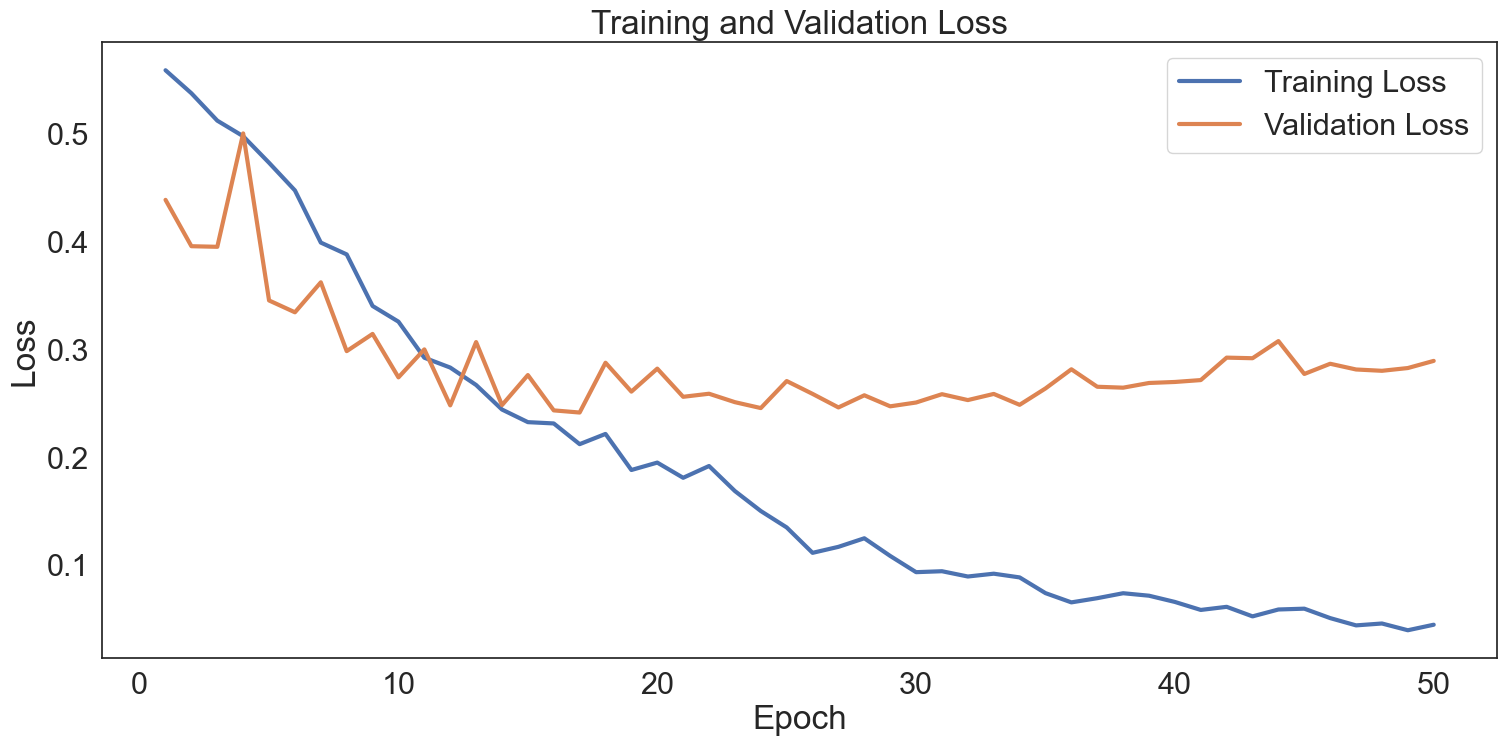

In [13]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(18,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss',linewidth=3.0)
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss',linewidth=3.0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 599, 28)        │         2,828 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 299, 28)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 299, 28)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8372)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,373 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,605 (131.27 KB)

 Trainable params: 11,201 (43.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,404 (87.52 KB)

In [76]:
loaded_model = load_model(os.path.join(MODEL, "qc_model.keras"))

for file_name in os.listdir(DATASET_QC_TEST):
    file_path = os.path.join(DATASET_QC_TEST, file_name)
    with open(file_path, 'r') as signal_file:
        signal = np.loadtxt(signal_file)
        prediction = loaded_model.predict(np.expand_dims(signal, axis=0))  
        binary_prediction = 1 if prediction > 0.5 else 0  
        print(f"File: {file_name}, Prediction: {binary_prediction}")

        
# predictions = loaded_model.predict(DATASET_QC_TEST)
# binary_predictions = (predictions > 0.5).astype(int)
# accuracy = accuracy_score(y_test, binary_predictions)
# precision = precision_score(y_test, binary_predictions)
# recall = recall_score(y_test, binary_predictions)
# f1 = f1_score(y_test, binary_predictions)

# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
File: s0322-07052204_31_p_signal.txt, Prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
File: s0322-07052204_54_p_signal.txt, Prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
File: s0322-07052204_22_p_signal.txt, Prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
File: s0402-08010704_64_p_signal.txt, Prediction: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
File: s0402-08010704_24_p_signal.txt, Prediction: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
File: s0402-08010704_98_p_signal.txt, Prediction: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
File: s0402-08010704_79_p_signal.txt, Prediction: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
File: s0322-07052204_21_p_signal.txt, Prediction: 0


s0322-07052204_31_p_signal.txt
0 0
s0322-07052204_54_p_signal.txt
0 1
s0322-07052204_22_p_signal.txt
1 0
s0402-08010704_64_p_signal.txt
1 1
s0402-08010704_24_p_signal.txt
2 0
s0402-08010704_98_p_signal.txt
2 1
s0402-08010704_79_p_signal.txt
3 0
s0322-07052204_21_p_signal.txt
3 1


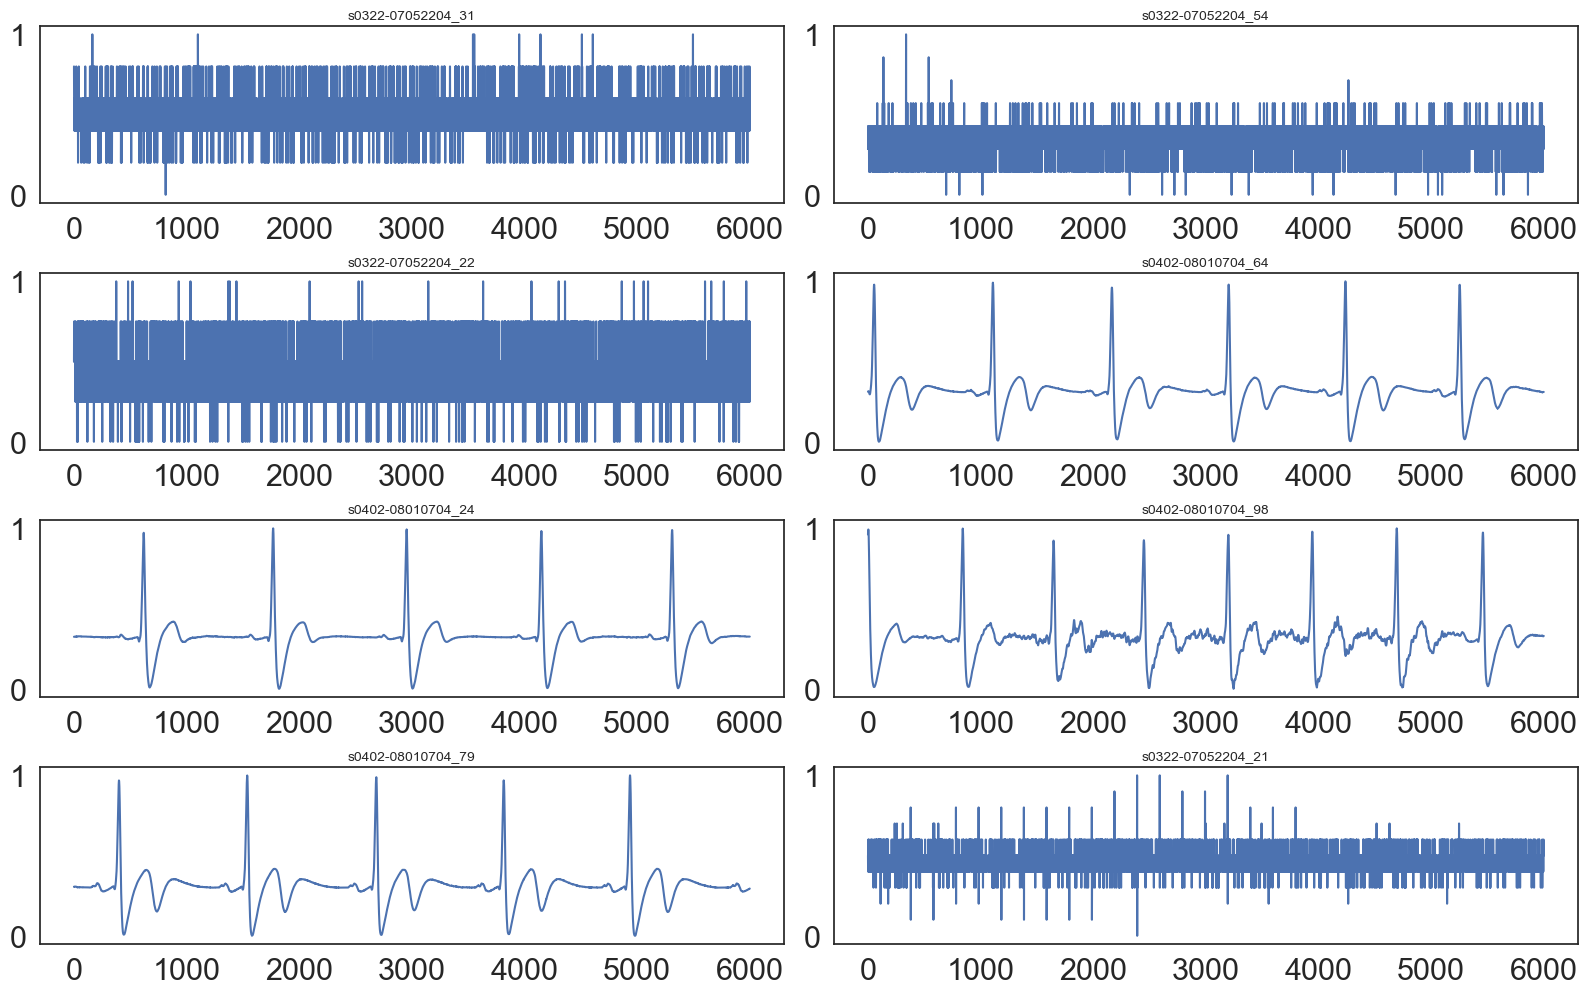

In [73]:
grid_plot(DATASET_QC_TEST, 1, 8, 2)